In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from PIL import Image, ImageOps
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Mounted at /content/drive


In [ ]:
imageDirectory = "/content/drive/pathToWhereImagesAre/"
inferencesDirectory = "/content/drive/pathToWhereYouWantInferencesToGo/"
modelDirectory = "/content/drive/Shareddrives/pathToModel/4:1:23 egg model/model"

In [ ]:
def getBorders(cv2Image):
  src = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
  src = cv2.blur(src,(src.shape[1], 1))
  src = cv2.adaptiveThreshold(src,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,101,2)
  # cv2_imshow(src)
  points = np.sum(src, axis = 1)
  points = signal.savgol_filter(points, 300, 2)
  plt.cla()
  plt.plot(range(len(points)), points)
  peaks, _ = signal.find_peaks(points, distance = 1000)
  # plt.plot(peaks[0], points[peaks[0]], "x")
  # plt.plot(peaks[-1], points[peaks[-1]], "x")
  row1 = peaks[0]
  row2 = peaks[-1]
  src = cv2.cvtColor(cv2Image, cv2.COLOR_BGR2GRAY)
  src = cv2.blur(src,(1, src.shape[0]))
  src = cv2.adaptiveThreshold(src,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,101,2)
  # cv2_imshow(src)
  points = np.sum(src, axis = 0)
  points = signal.savgol_filter(points, 300, 2)
  plt.plot(range(len(points)), points)
  peaks, _ = signal.find_peaks(points, distance = 700)
  # plt.plot(peaks[0], points[peaks[0]], "x")
  # plt.plot(peaks[-1], points[peaks[-1]], "x")
  column1 = peaks[0]
  column2 = peaks[-1]
  if(abs((column2 - column1) - 4365) > 200):
    print("col corrected")
    column1 = 227
    column2 = 4643
  if(abs((row2 - row1) - 2100) > 150):
    print("row corrected")
    row1 = 725
    row2 = 2979
  return([row1, row2, column1, column2])

def tupleToList(t):
    return list(map(tupleToList, t)) if isinstance(t, (list, tuple)) else t

def cropSquareFromContour(c, img):

    rect = cv2.minAreaRect(c)

    rect = tupleToList(rect)
    rect[1][0] = max(rect[1])
    rect[1][1] = max(rect[1])

    box = cv2.boxPoints(rect)
    box = np.int0(box)

    width = int(rect[1][0])
    height = int(rect[1][1])

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))

    return warped

def cropRectangleFromContour(c, img):

    rect = cv2.minAreaRect(c)

    box = cv2.boxPoints(rect)
    box = np.int0(box)
    width = int(rect[1][0])
    height = int(rect[1][1])

    src_pts = box.astype("float32")
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(img, M, (width, height))

    return warped

# def classifyObject(image):
#   image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
#   image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)
#   # image = (image / 127.5) - 1
#   image = image / 255
#   prediction = model.predict(image, verbose = 0)
#   return(prediction)

def classifyObject(cv2Image):
  img = cv2Image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = Image.fromarray(img)
  width_height_tuple = (224, 224)
  width, height = img.size
  target_width, target_height = width_height_tuple
  crop_height = (width * target_height) // target_width
  crop_width = (height * target_width) // target_height
  crop_height = min(height, crop_height)
  crop_width = min(width, crop_width)
  crop_box_hstart = (height - crop_height) // 2
  crop_box_wstart = (width - crop_width) // 2
  crop_box_wend = crop_box_wstart + crop_width
  crop_box_hend = crop_box_hstart + crop_height
  crop_box = [
      crop_box_wstart, crop_box_hstart, crop_box_wend,
      crop_box_hend
  ]
  img = img.resize(width_height_tuple, Image.NEAREST, box=crop_box)
  my_image = img_to_array(img)
  my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
  my_image = my_image / 255.
  prediction = model.predict(my_image, verbose = False)
  return(prediction)

In [ ]:
model = tf.keras.models.load_model(modelDirectory)
if("inferencesInProgress.csv" in os.listdir(inferencesDirectory)):
  inferences = pd.read_csv(inferencesDirectory + "inferencesInProgress.csv")
else:
  inferences = pd.DataFrame(columns = ['imageCode', 'count'])
print(inferences)

                             imageCode  count
0           GRKN_GS20_02_15_1_0235.jpg      3
1           GRKN_GS20_02_15_1_0236.jpg      5
2           GRKN_GS20_02_15_1_0237.jpg     10
3           GRKN_GS20_02_15_1_0238.jpg      4
4           GRKN_GS20_02_15_1_0239.jpg      6
...                                ...    ...
1333  Javanica_Tomato_Sucrosed0053.jpg      3
1334  Javanica_Tomato_Sucrosed0054.jpg      2
1335  Javanica_Tomato_Sucrosed0055.jpg      2
1336  Javanica_Tomato_Sucrosed0056.jpg      3
1337  Javanica_Tomato_Sucrosed0057.jpg      4

[1338 rows x 2 columns]


0.5_Javanica_Unsucrosed_0013.jpg
49
0.5_Javanica_Unsucrosed_0013.jpg
done


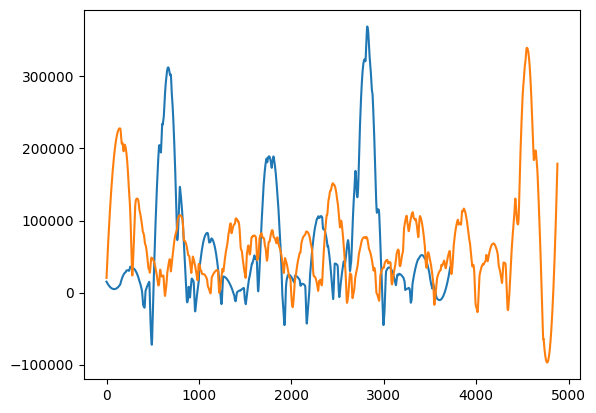

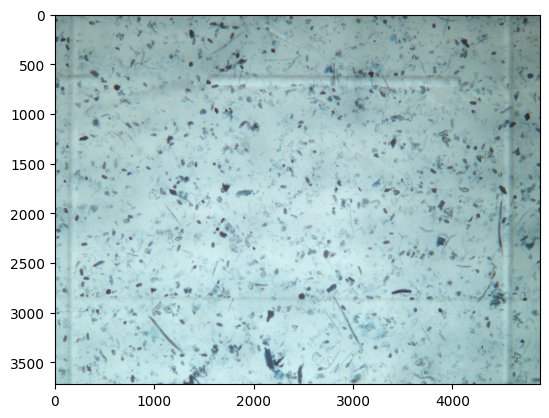

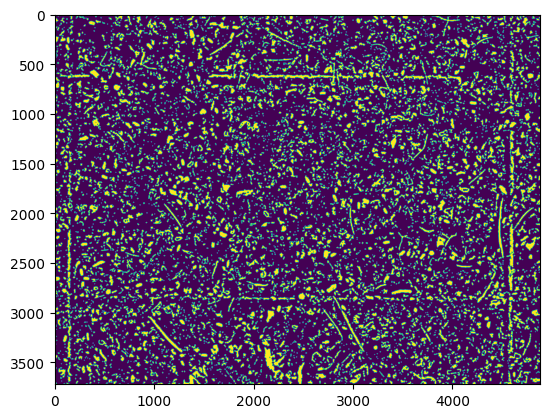

In [ ]:
inferences = pd.DataFrame(columns = ['imageCode', 'count'])
with tf.device('/device:GPU:0'):
  for file in os.listdir(imageDirectory):

      thisImageCode = str(os.path.splitext(os.path.basename(file))[0])
      if((thisImageCode + ".jpg") in list(inferences['imageCode'])):
        continue

      print(file)

      full_file = os.path.join(imageDirectory, file)

      img = cv2.imread(full_file)
      thisBorders = getBorders(img)

  # Convert to grayscale for binarization later
      img_gray = cv2.imread(full_file, cv2.IMREAD_GRAYSCALE)

  # Binarize image with adaptive threshold
      thres = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                  cv2.THRESH_BINARY_INV,101,2)

  # TUNE: KERNEL SIZE
  # Preprocess image, morphologically open image, removes small spots
      kernel = np.ones((7, 7), np.uint8)
      thres = cv2.morphologyEx(thres, cv2.MORPH_OPEN, kernel)

      plt.figure()
      plt.imshow(img)
      plt.figure()
      plt.imshow(thres)

  # Get all contours
      cnts, _ = cv2.findContours(thres, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

      cnts_filtered = []

      for c in cnts:
          area = cv2.contourArea(c)

          # TUNE: AREA THRESHOLD
          # Filter by area
          if(area < 4000 and area > 1500):
              width = min(cv2.minAreaRect(c)[1])
              length = max(cv2.minAreaRect(c)[1])

              # TUNE: L, W, LW THRESHOLD
              if(length > 40 and length < 150 and length/width > 1.5 and length/width < 5):

                thisObject = cropSquareFromContour(c, img)

                modelClasses = ("egg", "not egg")
                for i in range(4):
                  prediction = modelClasses[np.argmax(classifyObject(thisObject))]
                  if prediction == "not egg":
                    break
                  thisObject = cv2.rotate(thisObject, cv2.ROTATE_90_CLOCKWISE)

                if(prediction == "egg"):
                    objectIsInFrame = (
                      thisBorders[0] < c.flatten()[1] < thisBorders[1] and
                      thisBorders[2] < c.flatten()[0] < thisBorders[3]
                      )
                    if(objectIsInFrame):
                      cnts_filtered.append(c)
                else:
                  pass

      inferences.loc[inferences.shape[0]] = [file, len(cnts_filtered)]

      print(str(len(cnts_filtered)))

      cv2.rectangle(img, (thisBorders[2], thisBorders[0]), (thisBorders[3], thisBorders[1]), 1, 10)
      cv2.drawContours(img, cnts_filtered, -1, (0,255, 20), 6)
      img = cv2.putText(img, 'Egg count: ' + str(len(cnts_filtered)), (100, 100), 1, 8, 1, 10)
      print(file)

      cv2.imwrite(inferencesDirectory + file, img)
      inferences.to_csv(inferencesDirectory + 'inferencesInProgress.csv', index = False)
      break

print("done")
inferences.to_csv(inferencesDirectory + 'inferences.csv', index = False)